In [74]:
def ploty_scatter(x , y ):
    # Create a trace
    trace = go.Scatter(
        x = x,   
        y = y,   
        mode = 'markers', 
        marker=dict(color= x , colorscale=colorscale ) 
    ) 
    layout = go.Layout( 
        plot_bgcolor = '#FFFFFF',
        paper_bgcolor = '#FFFFFF' 
    )
    data = [trace] 
    fig = go.Figure(data = data, layout = layout)
    # Plot and embed in ipython notebook!
    #py.iplot(fig ,   filename='simple_scatter') 
    return fig

In [105]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%d" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [73]:
colorscale =[ 
            [0.0                 ,  '#cecece',], 
            [0.047619047619047616,  '#ffff00',],
            [0.09523809523809523 ,  '#fff21d',],
            [0.14285714285714285 ,  '#ffe52a',],
            [0.19047619047619047 ,  '#ffd733',],
            [0.23809523809523808 ,  '#ffca3a',],
            [0.2857142857142857  ,  '#ffbd40',],
            [0.3333333333333333  ,  '#ffad45',],
            [0.38095238095238093 ,  '#ffa049',],
            [0.42857142857142855 ,  '#ff904d',],
            [0.47619047619047616 ,  '#ff7f50',],
            [0.5238095238095237  ,  '#ff7f50',],
            [0.5714285714285714  ,  '#f47263',],
            [0.6190476190476191  ,  '#e96673',],
            [0.6666666666666667  ,  '#dd5a83',],
            [0.7142857142857144  ,  '#cf4d92',],
            [0.7619047619047621  ,  '#c040a1',],
            [0.8095238095238098  ,  '#b033af',],
            [0.8571428571428574  ,  '#9e25be',],
            [0.9047619047619051  ,  '#8615cd',],
            [0.9523809523809528  ,  '#6900db',], 
            [1                   ,  '#3d3d3d']]

In [96]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.plotly as py
import plotly.graph_objs as go 
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min 
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics 
from sklearn.metrics import davies_bouldin_score 
import hdbscan 
from scipy.cluster.hierarchy import linkage , dendrogram

#plotly.tools.set_credentials_file(username='slotbite', api_key='GYgRt3eXz6IdiIy3k7sO')
py.plotly.tools.set_credentials_file(username='cachulooo', api_key='srvpWbqoQ27WdGO3pArx')

 
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 12)
np.set_printoptions(precision=2, suppress=True)  # suppress scientific float notation

In [97]:
# Cargando datos
df = pd.read_csv("segmentacion_clientes.csv" , delimiter=";" , decimal="," , encoding='utf-8')

In [98]:
# Eliminacion de outliers (-)
df = df[df.PRODUCT_ID > 0] 
df = df[(df.FACTURACION_PROMEDIO > 0 ) & (df.FACTURACION_PROMEDIO <= 397000 )] 
df = df[(df.SALDO_PROMEDIO > 0 ) & (df.SALDO_PROMEDIO <= 401500 )]  


## Convertimos las variables categoricas
#http://pbpython.com/categorical-encoding.html
pd.options.mode.chained_assignment = None
df["COMUNA"] = df["COMUNA"].astype('category')
df["TIPO_REPARTO"] = df["TIPO_REPARTO"].astype('category')
df["TI"] = df["TI"].astype('category')
df["TI2"] = df["TI2"].astype('category')

# luego la encodificamos 
df["TI"] = df["TI"].cat.codes
df["TI2"] = df["TI2"].cat.codes
df["COMUNA_ENC"] = df["COMUNA"].cat.codes 
df["TIPO_REPARTO"] = df["TIPO_REPARTO"].cat.codes 
df[:3]

,PRODUCT_ID,SUBSCRIPTION_ID,SUBSCRIBER_ID,COMUNA,TI,TI2,TIPO_REPARTO,QUEJAS,DAÑOS,CORTES,RECLAMOS,FACTURACION_PROMEDIO,SALDO_PROMEDIO,ROTACION_CARTERA,COMUNA_ENC
0,122551,122551,13185036,128 - San Esteban ...,0,0,0,0,0,0,0,18964.8333,33256.6667,1.753504,8
1,122581,122581,122581,128 - San Esteban ...,0,0,0,0,0,0,0,28445.7500,36605.0833,1.286793,8
2,109938,109938,3665521,145 - San Felipe ...,0,1,0,0,0,1,0,135045.4170,327823.5000,2.427488,18


In [99]:
df.columns

Index(['PRODUCT_ID', 'SUBSCRIPTION_ID', 'SUBSCRIBER_ID', 'COMUNA', 'TI', 'TI2',
       'TIPO_REPARTO', 'QUEJAS', 'DAÑOS', 'CORTES', 'RECLAMOS',
       'FACTURACION_PROMEDIO', 'SALDO_PROMEDIO', 'ROTACION_CARTERA',
       'COMUNA_ENC'],
      dtype='object')

In [100]:
columnas=['SALDO_PROMEDIO', 'ROTACION_CARTERA','FACTURACION_PROMEDIO','TI', 'TI2',
          'TIPO_REPARTO', 'QUEJAS', 'DAÑOS', 'CORTES', 'RECLAMOS','COMUNA_ENC']

In [101]:
frac= 0.0001
random = 42  
sample = df[columnas].sample(frac=frac )

In [68]:
sample.shape 

(58, 11)

In [109]:
fig = ploty_scatter( sample.SALDO_PROMEDIO , sample.ROTACION_CARTERA )
py.iplot(fig ,   filename='scatter_hdbscan')

In [102]:
mergings = linkage(sample , method='ward')

In [103]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist ,  squareform

c, coph_dists = cophenet(mergings, pdist(sample))
c

0.8890756127141494

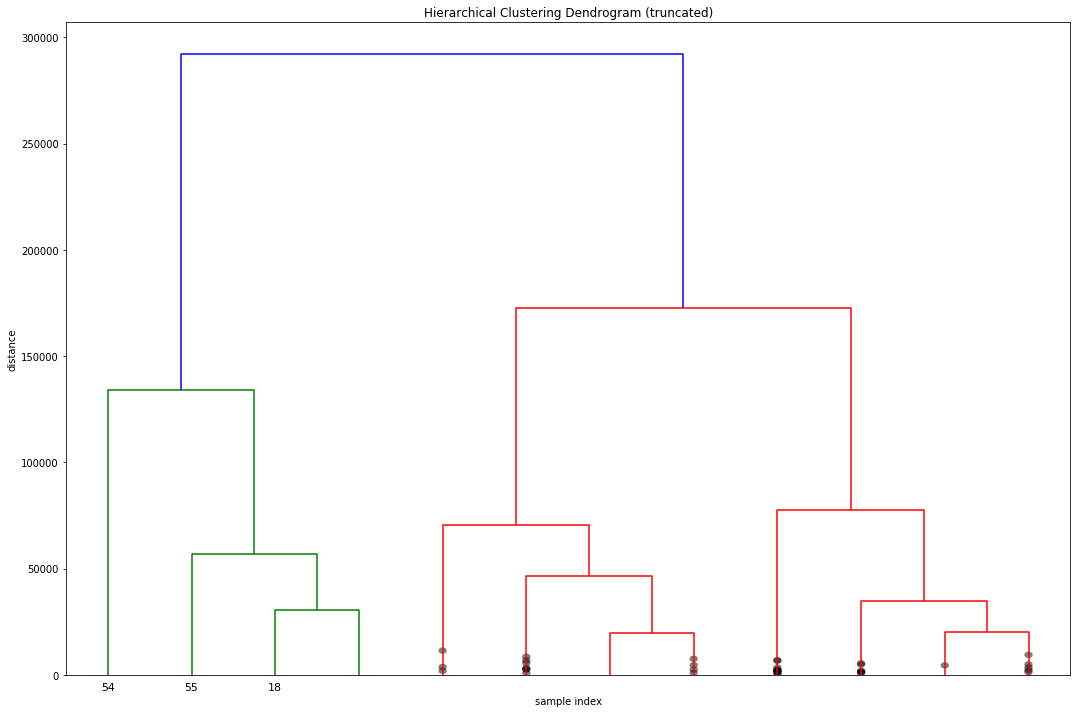

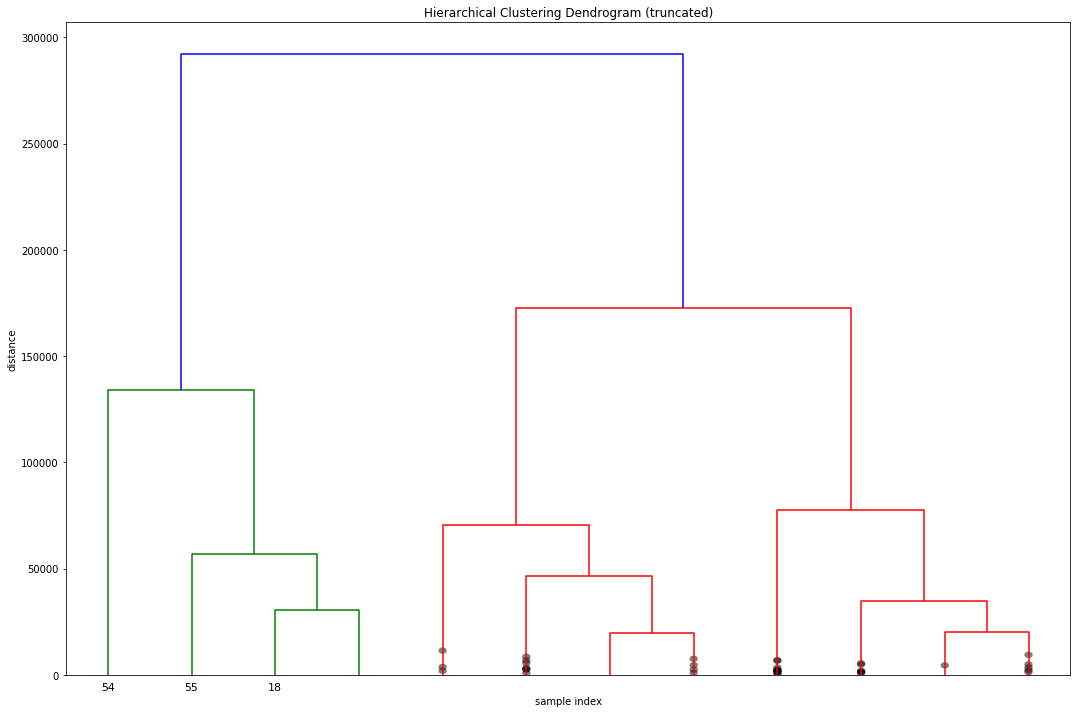

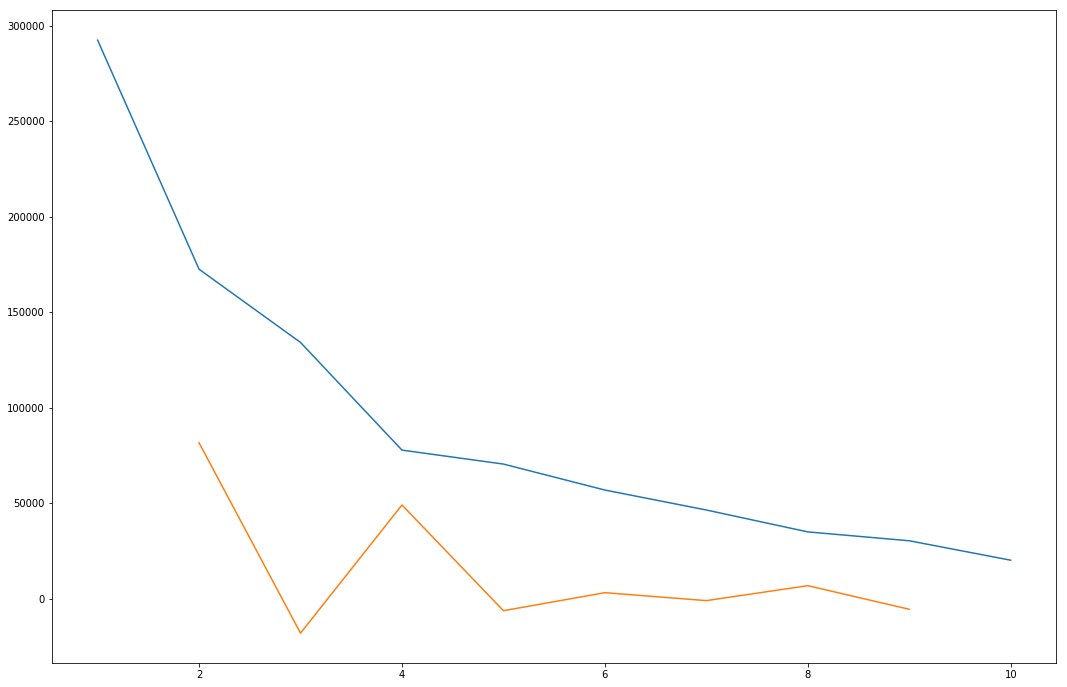

clusters: 2


In [80]:
last = mergings[-10:, 2] 
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:" , k)

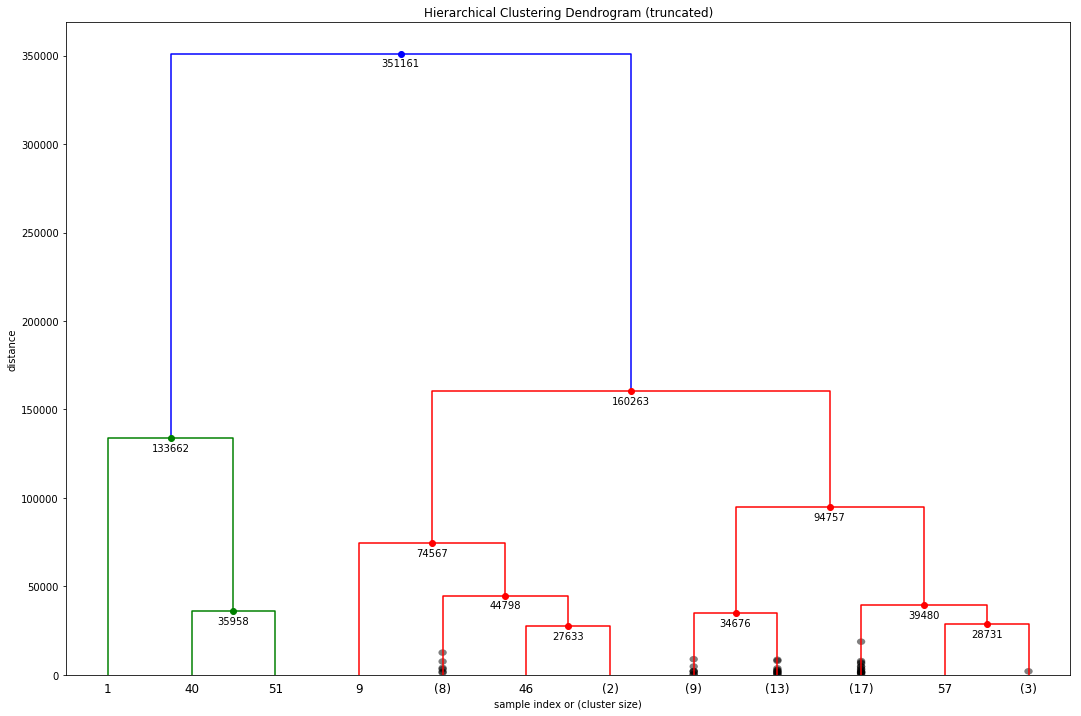

In [179]:
ddata = fancy_dendrogram(
    mergings,
    truncate_mode='lastp',
    p=12, 
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

TypeError: unhashable type: 'slice'

In [147]:
from scipy.spatial.distance import pdist ,  squareform

data_dist = pdist(sample ) # computing the distance
mergings = linkage(data_dist , method='ward') # computing the linkage
#mergings = linkage(sample , method='ward')

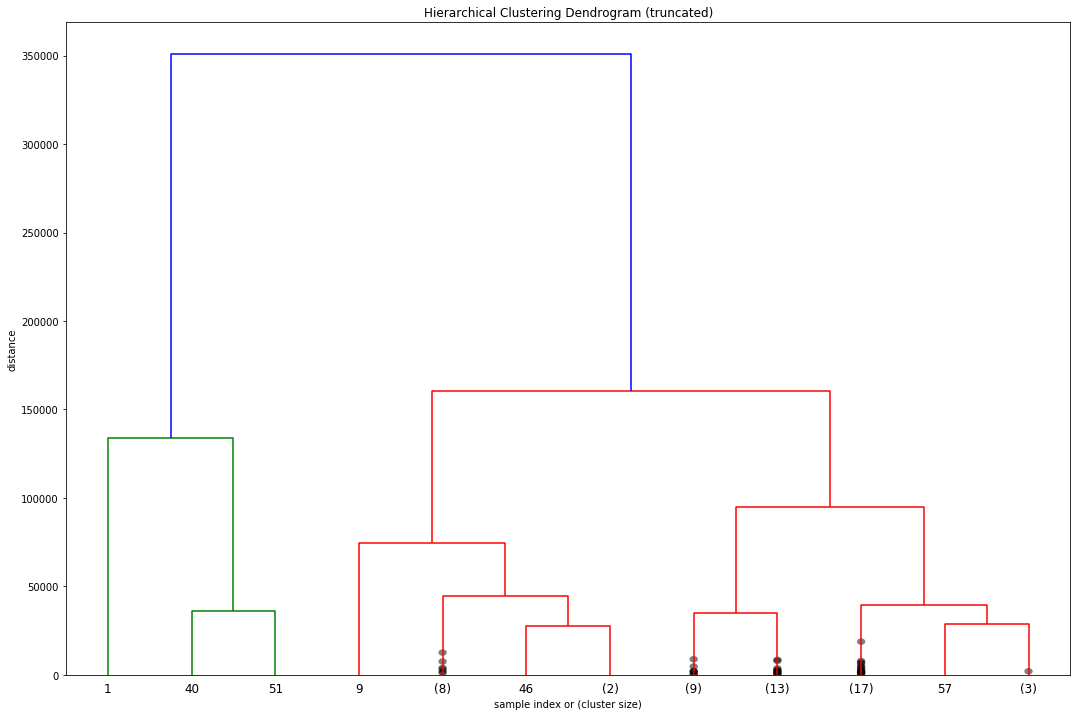

In [155]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
ddata = dendrogram(
    mergings,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged cluster
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [196]:
'''
Retorna una lista con las distancias ordenadas del grafico
'''
def get_distances(ddata):
    arr_distances =[]
    for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):

        arr_distances.append( int(round(d[1] , 0) )) 

    return arr_distances.sort()  

In [152]:
from scipy.cluster.hierarchy import fcluster 
from sklearn.metrics import silhouette_samples  # , silhouette_score
 
a  , b  =  single_silhouette_dendrogram( squareform(data_dist) , mergings   , 120000   )

In [153]:
b

0.5145816258615274

In [154]:
a

4

In [114]:
def single_silhouette_dendrogram(dist_matrix, Z, threshold, mode='clusters',
                                 method='single', sample_names=None):
    """Compute the average silhouette at a given threshold.

    Parameters
    ----------
    dist_matrix : array-like
        Precomputed distance matrix between points.
    Z : array-like
        Linkage matrix, results of scipy.cluster.hierarchy.linkage.
    threshold : float
        Specifies where to cut the dendrogram.
    mode : ('clusters', 'thresholds'), optional
        Choose what to visualise on the x-axis.

    Returns
    -------
    x : float
        Based on mode, it can contains the number of clusters or threshold.
    silhouette_avg : float
        The average silhouette.
    """
    cluster_labels = fcluster(Z, threshold, 'distance')
    nclusts = np.unique(cluster_labels).shape[0]
  
    try:
        silhouette_list = silhouette_samples(dist_matrix, cluster_labels,
                                             metric="precomputed")
        silhouette_avg = np.mean(silhouette_list)
        x = max(cluster_labels) if mode == 'clusters' else threshold
    except ValueError as e:
        if max(cluster_labels) == 1:
            x = 1 if mode == 'clusters' else threshold
            silhouette_avg = 0
        else:
            raise(e)

    return x, silhouette_avg